# Intro

Welcome to the interactive tracking notebook!\
This notebook goes through each step and allows you to tune parameters and view how it changes the results.

The notebook proceeds as follows:
1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**. Each step of the pipeline is run by a single unique python class.
4. **Visualize** results
5. **Save** results

As you go through the notebook, take note of the small number of parameters that are mentioned as **'important parameters'** (consider searching for these in the notebook). We consider these to be the only parameters that can have a large effect on the run output. Other parameters matter and should be considered as well, but are less critical.

# Import libraries

Widen the notebook

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

Import basic libraries

In [2]:
from pathlib import Path
import copy
import multiprocessing as mp
import tempfile

import matplotlib.pyplot as plt
import numpy as np

Import `roicat`

In [3]:
import roicat

# Find paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [4]:
# dir_allOuterFolders = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_2_6/stat_and_ops/'

# pathSuffixToStat = 'stat.npy'
# pathSuffixToOps = 'ops.npy'

# paths_allStat = roicat.helpers.find_paths(
#     dir_outer=dir_allOuterFolders,
#     reMatch=pathSuffixToStat,
#     depth=6,
# )[:]
# paths_allOps  = np.array([Path(path).resolve().parent / pathSuffixToOps for path in paths_allStat])[:]

# print(f'paths to all stat files:');
# [print(path) for path in paths_allStat];
# print('');
# print(f'paths to all ops files:');
# [print(path) for path in paths_allOps];

In [5]:
path1 = Path("/data/multiplane-ophys_636496_2022-09-22_10-11-58_processed_2024-02-15_17-50-57/1213469388/")
path2 = Path("/data/multiplane-ophys_636496_2022-09-23_10-50-32_processed_2024-02-15_17-51-34/1213735991/")

# Import data

**Important parameters**:
- `um_per_pixel` (float):
    - Resolution. 'micrometers per pixel' of the imaging field of view.

In [6]:
# data = roicat.data_importing.Data_suite2p(
#     paths_statFiles=paths_allStat[:],
#     paths_opsFiles=paths_allOps[:],
#     um_per_pixel=1.6,  ## IMPORTANT PARAMETER
#     new_or_old_suite2p='new',
#     type_meanImg='meanImgE',
# #     FOV_images=FOVs_mixed,
#     verbose=True,
# )

# assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

**Replace above with code to read from LIMS format**

In [7]:
from PIL import Image
import json

In [8]:
data = roicat.data_importing.Data_roicat()

In [9]:
## FOV images
fov1 = Image.open(path1 / "motion_correction/1213469388_average_projection.png")
fov2 = Image.open(path2 / "motion_correction/1213735991_average_projection.png")
data.set_FOV_images([np.array(fov1), np.array(fov2)])

Completed: Set FOV_images for 2 sessions successfully.


In [10]:
## spatial footprints

def lims2dense(rois, dims):
    N = len(rois)
    masks = np.zeros((N,) + dims)
    for i, roi in enumerate(rois):
        x,y,h,w = roi['x'], roi['y'], roi['height'], roi['width']
        masks[i, y:y+h,x:x+w] = roi['mask_matrix']
    return masks

with open(path1 / "segmentation/segmentation_output.json", 'r') as file:
    rois = json.load(file)
    rois1 = lims2dense(rois, fov1.size)
with open(path2 / "segmentation/segmentation_output.json", 'r') as file:
    rois = json.load(file)
    rois2 = lims2dense(rois, fov2.size)

data.set_spatialFootprints([rois1, rois2])
data.set_ROI_images([rois1, rois2], um_per_pixel=.78)
# ## Transform spatial footprints to ROI images
# data._transform_spatialFootprints_to_ROIImages(out_height_width=out_height_width)

RH WARNING: spatialFootprints are numpy.ndarray objects. Assuming structure is a list of arrays (1 per session) of shape (n_roi, height, width), converting them to scipy.sparse.csr_matrix objects.


/opt/conda/lib/python3.10/site-packages/roicat/data_importing.py:365: UserWarning: RH WARNING: No um_per_pixel provided. We recommend making an educated guess. Assuming 1.0 um per pixel. This will affect the embedding results.
  warnings.warn("RH WARNING: No um_per_pixel provided. We recommend making an educated guess. Assuming 1.0 um per pixel. This will affect the embedding results.")


Completed: Set FOV_height and FOV_width successfully.
Completed: Set spatialFootprints for 2 sessions successfully.
Starting: Importing ROI images
Completed: Imported 2 sessions. Each session has [89, 98] ROIs. Total number of ROIs is 187. The um_per_pixel is 0.78 um per pixel.


In [11]:
assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking"

**Despite above check_completeness succeeds, we still need to do below for the notebook to run to completion**

In [12]:
 ## Make session_bool
data._make_session_bool()

## Make spatial footprint centroids
data._make_spatialFootprintCentroids()

Completed: Created session_bool.
Completed: Created centroids.



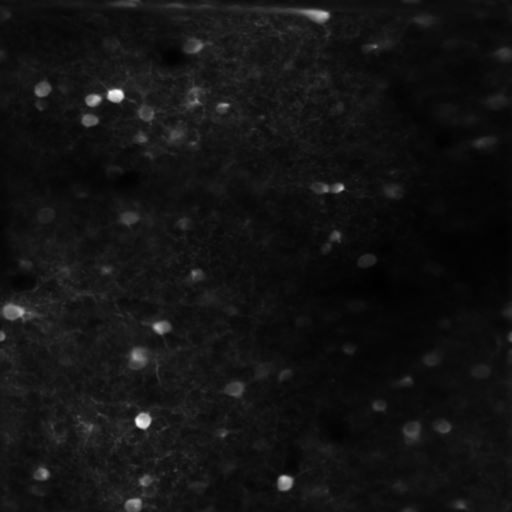


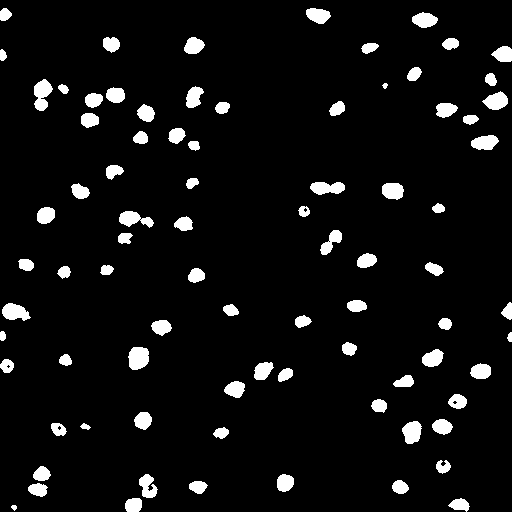


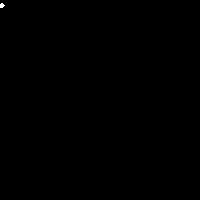

In [13]:
roicat.visualization.display_toggle_image_stack(data.FOV_images)
roicat.visualization.display_toggle_image_stack(data.get_maxIntensityProjection_spatialFootprints(), clim=[0,1])
roicat.visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0)[:5000], image_size=(200,200))

# Alignment

This is the most important step in the pipeline to stop and check that everything looks okay and tune parameters if necessary. I strongly recommend reading the documentation for the methods for the `roicat.tracking.alignment.Aligner` class at each step.

Alignment is 4 steps:

1. FOV_image augmentation
2. Fit geometric transformation
3. Fit non-rigid transformation (on top of the geometric)
4. Apply transformation to ROIs

##### 1. FOV_image augmentation
Do what is necessary to make the augmented FOV_images look good. Use the visualization tool below to help. This can include using different FOV_images, playing with the mixing factor, and playing with the CLAHE parameters.

In [14]:
aligner = roicat.tracking.alignment.Aligner(verbose=True)

FOV_images = aligner.augment_FOV_images(
    ims=data.FOV_images,
    spatialFootprints=data.spatialFootprints,
    roi_FOV_mixing_factor=0.5,
    use_CLAHE=True,
    CLAHE_grid_size=1,
    CLAHE_clipLimit=1,
    CLAHE_normalize=True,
)

View the augmented FOV images


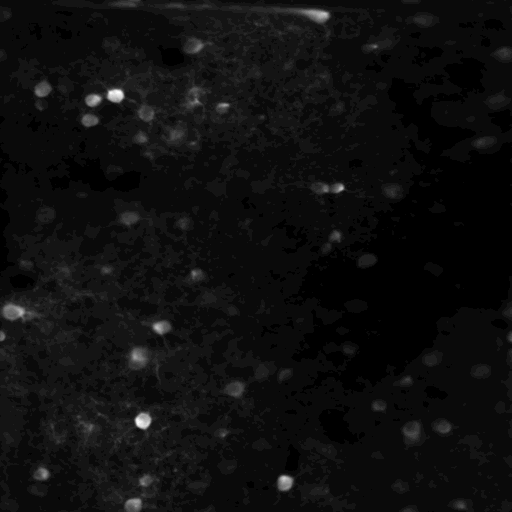

In [15]:
roicat.visualization.display_toggle_image_stack(FOV_images)

##### 2. Fit geometric transformation
Play with parameters until the aligned FOV_images look good. The visualization tool below can help. Please consider reading the documentation if you have any issues with the alignment step (TODO: link to readthedocs) for more details.

We like the following **important parameters**:
- `template`=0.5

In [16]:
aligner.fit_geometric(
#     template=FOV_images[4],
    template=0.5,  ## specifies which image to use as the template. Either array (image), integer (ims_moving index), or float (ims_moving fractional index)
    ims_moving=FOV_images,  ## input images
    template_method='sequential',  ## 'sequential': align images to neighboring images (good for drifting data). 'image': align to a single image
    mode_transform='homography',  ## type of geometric transformation. See openCV's cv2.findTransformECC for details
    mask_borders=(50,50,50,50),  ## number of pixels to mask off the edges (top, bottom, left, right)
    n_iter=50,  ## number of iterations for optimization
    termination_eps=1e-09,  ## convergence tolerance
    gaussFiltSize=31,  ## size of gaussian blurring filter applied to all images
    auto_fix_gaussFilt_step=10,  ## increment in gaussFiltSize after a failed optimization
)

aligner.transform_images_geometric(FOV_images);

Converting float fractional index to integer index: 0.5 -> 1
Finding geometric registration warps with mode: homography, template_method: sequential, mask_borders: True


Finding geometric registration warps: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

Composing geometric warp matrices...
Applying geometric registration warps to images...


##### 3. Fit non-rigid transformation
Play with parameters until the aligned FOV_images look good. The visualization tool below can help.

We like the following **important parameters**:
- `template`=0.5
- `template_method`='image'


In [17]:
aligner.fit_nonrigid(
#     template=FOV_images[1],
    template=0.5,  ## specifies which image to use as the template. Either array (image), integer (ims_moving index), or float (ims_moving fractional index)
    ims_moving=aligner.ims_registered_geo,  ## Input images. Typically the geometrically registered images
    remappingIdx_init=aligner.remappingIdx_geo,  ## The remappingIdx between the original images (and ROIs) and ims_moving
    template_method='image',  ## 'sequential': align images to neighboring images. 'image': align to a single image, good if using geometric registration first
    mode_transform='createOptFlow_DeepFlow',  ## algorithm for non-rigid transformation. Either 'createOptFlow_DeepFlow' or 'calcOpticalFlowFarneback'. See openCV docs for each. 
    kwargs_mode_transform=None,  ## kwargs for `mode_transform`
)

aligner.transform_images_nonrigid(FOV_images);

Converting float fractional index to integer index: 0.5 -> 1
Finding nonrigid registration warps with mode: createOptFlow_DeepFlow, template_method: image


Finding nonrigid registration warps: 100%|██████████| 2/2 [00:00<00:00,  2.33image/s]

Composing nonrigid warp matrices...
Applying nonrigid registration warps to images...


##### 4. Transform ROIs

In [18]:
aligner.transform_ROIs(
    ROIs=data.spatialFootprints, 
    remappingIdx=aligner.remappingIdx_nonrigid,
    normalize=True,
);

Registering ROIs...



Registering ROIs: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Ensure that the aligned FOVs look aligned

Pre-alignment below



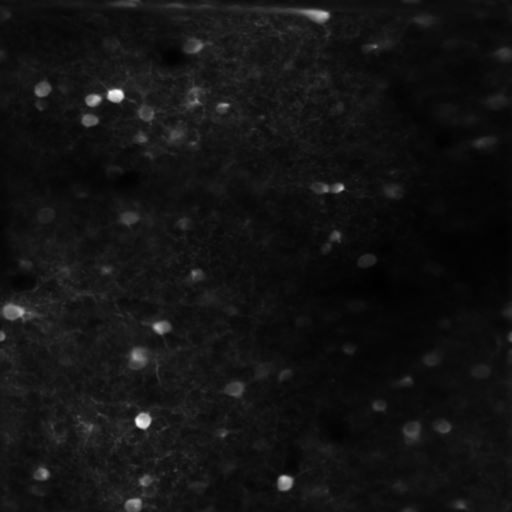

Geometric alignment below



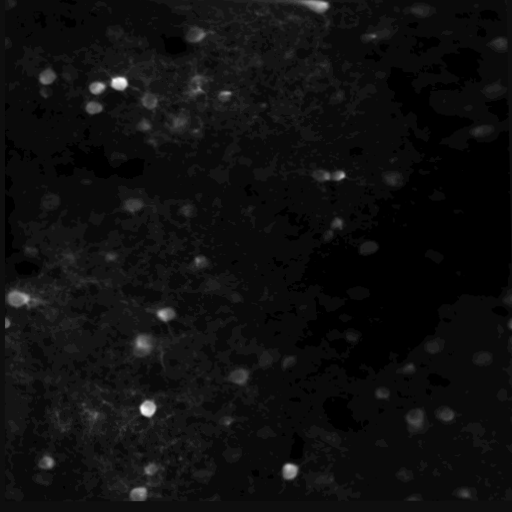

Non-rigid alignment below



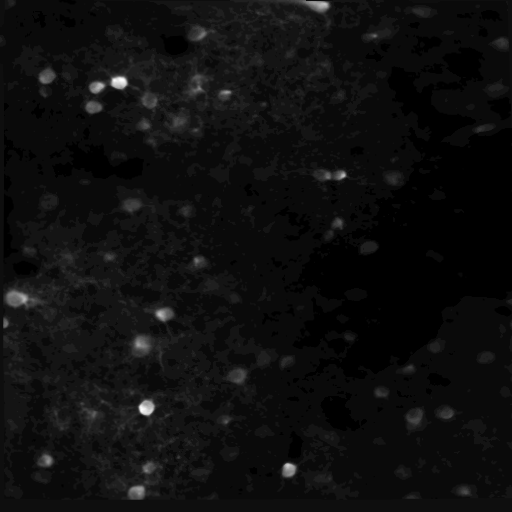

Transformed ROIs below



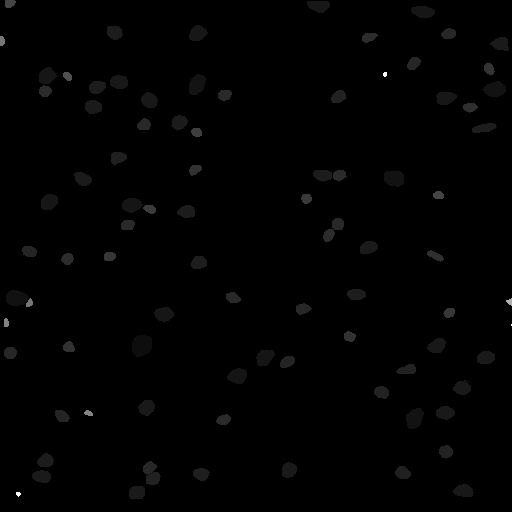

In [19]:
print(f'Pre-alignment below')
roicat.visualization.display_toggle_image_stack(data.FOV_images)
print(f'Geometric alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_geo)
print(f'Non-rigid alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_nonrigid)
print(f'Transformed ROIs below')
roicat.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=(0, 0.05))

# Blur ROIs

ROIs from different sessions with zero spatial overlap have very low probability of being considered the same ROI. Blurring the spatial footprint masks can increase the overlap between ROIs that drift apart from each other. 

In [20]:
blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),  ## FOV height and width
    kernel_halfWidth=2,  ## The half width of the 2D gaussian used to blur the ROI masks
    plot_kernel=False,  ## Whether to visualize the 2D gaussian
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
);

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


See that the blurred ROIs are overlapping each other


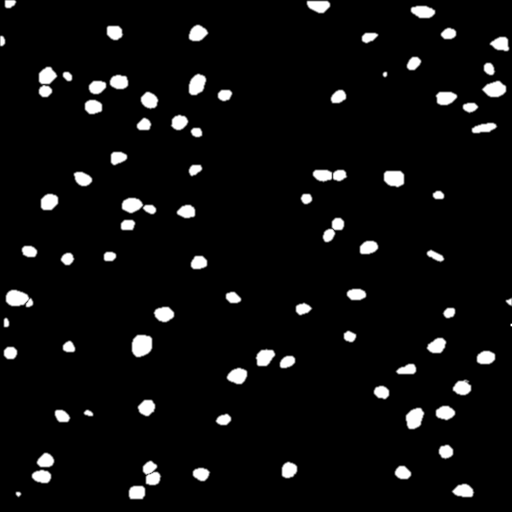

In [21]:
roicat.visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

Initialize the ROInet object. The `ROInet_embedder` class will automatically download and load a pretrained ROInet model. If you have a GPU, this step will be much faster.

In [22]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/x3fd2/download',  ## URL of the model
    download_hash='7a5fb8ad94b110037785a46b9463ea94',  ## Hash of the model file
    forward_pass_version='latent',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

devices available: [_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14928MB, multi_processor_count=40)]
Using device: 'cuda:0': _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14928MB, multi_processor_count=40)
File already exists locally: /tmp/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /tmp/ROInet.zip to /tmp.
Completed zip extraction.
Imported model from /tmp/ROInet_tracking_20220527/model.py
Loaded params_model from /tmp/ROInet_tracking_20220527/params.json


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /tmp/ROInet_tracking_20220527/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0


Resize ROIs and prepare a dataloader.

**Important parameters**:
- `um_per_pixel`: (same as specified in `data` object). Resolution of FOV. This is used to resize the ROIs to be relatively consistent across resolutions.

In [23]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
    
    jit_script_transforms=False,  ## (advanced) Whether or not to use torch.jit.script to speed things up
    
    batchSize_dataloader=8,  ## (advanced) PyTorch dataloader batch_size
    pinMemory_dataloader=True,  ## (advanced) PyTorch dataloader pin_memory
    numWorkers_dataloader=mp.cpu_count(),  ## (advanced) PyTorch dataloader num_workers
    persistentWorkers_dataloader=True,  ## (advanced) PyTorch dataloader persistent_workers
    prefetchFactor_dataloader=2,  ## (advanced) PyTorch dataloader prefetch_factor
);

Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


In general, you want to see that a neuron fills roughly 25-50% of the area of the image.

/opt/conda/lib/python3.10/site-packages/roicat/visualization.py:72: RuntimeWarning: invalid value encountered in divide
  norm_image = (image - clim[0]) / (clim[1] - clim[0])
/opt/conda/lib/python3.10/site-packages/roicat/visualization.py:74: RuntimeWarning: invalid value encountered in cast
  return (norm_image * 255).astype(np.uint8)



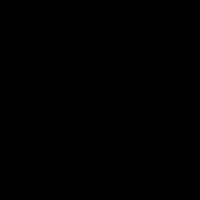

In [24]:
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs[:1000], image_size=(200,200))

Pass the data through the network. Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.

In [25]:
roinet.generate_latents();

starting: running data through network


100%|██████████| 24/24 [00:03<00:00,  6.82it/s]


completed: running data through network


# Scattering wavelet embedding

This is similar to the ROInet embedding in purpose.

In [26]:
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 12},  ## 'J' is the number of convolutional layers. 'L' is the number of wavelet angles.
    image_shape=data.ROI_images[0].shape[1:3],  ## size of a cropped ROI image
    device=DEVICE,  ## PyTorch device
)

swt.transform(
    ROI_images=roinet.ROI_images_rs,  ## All the cropped and resized ROI images
    batch_size=100,  ## Batch size for each iteration (smaller is less memory but slower)
);

SWT initialized
Starting: SWT transform on ROIs


  0%|          | 0/1.87 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
107%|██████████| 2/1.87 [00:05<00:00,  2.64s/it]


Completed: SWT transform on ROIs


# Compute similarities

Now we can compare the similarities of the ROIs. This includes calculating 4 kinds of similarities:
1. `s_sf`: 'similarity spatial footprint'. The physical overlap between ROIs.
2. `s_NN`: 'similarity neural network'. The similarities of the embeddings out of ROInet.
3. `s_SWT`: 'similarity scaterring wavelet transform'. The similarities of the embeddings out of the scattering wavelet transformer.
4. `s_sesh`: 'similarity sessions'. 0 if from the same session, 1 if from different sessions. ROIs from the same session have 0 probability of being the same.

The result of this step will be a set of pairwise similarity matrices.

Initialize the `ROI_graph` class and compute similarities.
To make computation more efficient, only ROIs within the same 'block' are compared against each other.

Computing pairwise similarity between ROIs...


100%|██████████| 16/16 [00:01<00:00, 10.97it/s]


Joining blocks into full similarity matrices...
Joining s_sf...
Joining s_NN...
Joining s_SWT...
Joining s_sesh...


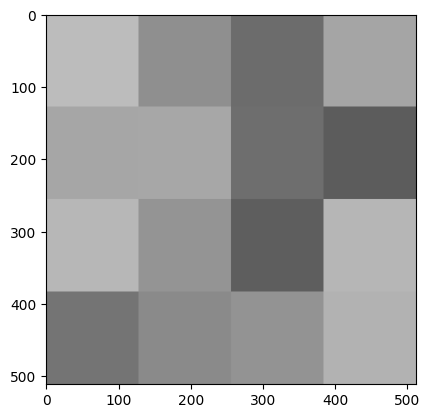

In [27]:
sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=-1,  ## Number of CPU cores to use. -1 for all.
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=128,  ## size of a block
    block_width=128,  ## size of a block
    algorithm_nearestNeigbors_spatialFootprints='brute',  ## algorithm used to find the pairwise similarity for s_sf. ('brute' is slow but exact. See docs for others.)
    verbose=True,  ## Whether to print outputs
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,  ## Mask spatial footprints
    features_NN=roinet.latents,  ## ROInet output latents
    features_SWT=swt.latents,  ## Scattering wavelet transform output latents
    ROI_session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
    spatialFootprint_maskPower=1.0,  ##  An exponent to raise the spatial footprints to to care more or less about bright pixels
);

It is useful to normalize the similarity matrices using the local ROIs.

In [28]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,  ## ROI centroid positions
    features_NN=roinet.latents,  ## ROInet latents
    features_SWT=swt.latents,  ## SWT latents
    k_max=data.n_sessions*100,  ## Maximum number of nearest neighbors to consider for the normalizing distribution
    k_min=data.n_sessions*10,  ## Minimum number of nearest neighbors to consider for the normalizing distribution
    algo_NN='kd_tree',  ## Nearest neighbors algorithm to use
    device=DEVICE,
)

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|██████████| 187/187 [00:00<00:00, 12214.77it/s]

Normalizing SWT similarity scores...



/opt/conda/lib/python3.10/site-packages/roicat/tracking/similarity_graph.py:422: RuntimeWarning: invalid value encountered in divide
  self.s_NN_z.data = ((self.s_NN_z.data - mus_NN_diff[self.s_NN_z.row]) / stds_NN_diff[self.s_NN_z.row])
100%|██████████| 187/187 [00:04<00:00, 44.15it/s]
/opt/conda/lib/python3.10/site-packages/roicat/tracking/similarity_graph.py:433: RuntimeWarning: invalid value encountered in divide
  self.s_SWT_z.data = ((self.s_SWT_z.data - mus_SWT_diff[self.s_SWT_z.row]) / stds_SWT_diff[self.s_SWT_z.row])


# Clustering

This step does the following:
1. Mix the similarity matrices into a single distance matrix
2. Prune the distance matrix to remove low probability connections
3. Perform clustering
4. Compute quality metrics

#### 1. Mix the similarity matrices into a single distance matrix

This step can be done either automatically, using the `clusterer.find_optimal_parameters_for_pruning` method, or manually by specifying the `kwargs_makeConjunctiveDistanceMatrix` dictionary.


##### Option A: Automatic Method
This step finds the optimal parameters to mix the similarity matrices by tuning mixing parameters to maximally separate the distributions of pairwise similarities for ROI pairs known to be different and ROI pairs that are likely matched.

Some of the details of underlying algorithm:
1. For each step in the optimization process, all the similarity matrices (`s_sf`, `s_NN_z`, `s_SWT_z`, `s_sesh`) are each passed through a sigmoid activation function that is parameterized (e.g. `'power_SF'`, `'sig_SF_kwargs'`), then all the similarity matrices are combined using a p-norm, where the 'p' is parameterized with `'p_norm'`. This results in a single conjunctive similarity matrix called `sConj` bounded between 0-1. 
2. `sConj` is converted into a distance matrix `dConj` (bounded from 1-0).
3. `dConj` is then passed through the objective function: The full distance matrix is separated into a few components. First, all pairs of ROIs that are known to be from 'different' sources because they are from the same session are separated out into a distribution of pairwise distances (`d_diff`). Second, we define pairs of ROIs that are likely to be from the same source as `d_same` = `d_all` - `d_diff`. The objective function is then the overlap between the `d_diff` and `d_same` distributions. 
4. The objective function is minimized by tuning the mixing parameters in `kwargs_makeConjunctiveDistanceMatrix`.
5. The output of this step is the optimal `kwargs_makeConjunctiveDistanceMatrix` dictionary.

##### Option B: Manual Method
You can also simply specify the `kwargs_makeConjunctiveDistanceMatrix` dictionary manually. This is useful if you have a good idea of what the optimal parameters are or if the automatic method is not working well. Uncomment the code block below to overwrite the `kwargs_mcdm_tmp` variable.

#### TROUBLESHOOTING FOR THIS STEP
- If you have any issues, just email Rich Hakim or open an issue on the github issues page.
- If you see: `'No crossover found, not plotting'`: Your data may not be easily separable. For some people, this is because the number of matching ROIs is very low compared to the number of non-matching ROIs. I recommend trying out the manual method.

In [29]:
## Initialize the clusterer object by passing the similarity matrices in
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=None,  ## Number of bins to use for the histograms of the distributions. If None, then a heuristic is used.
    smoothing_window_bins=None,  ## Number of bins to use to smooth the distributions. If None, then a heuristic is used.
    kwargs_findParameters={
        'n_patience': 300,  ## Number of optimization epoch to wait for tol_frac to converge
        'tol_frac': 0.001,  ## Fractional change below which optimization will conclude
        'max_trials': 1200,  ## Max number of optimization epochs
        'max_duration': 60*10,  ## Max amount of time (in seconds) to allow optimization to proceed for
    },
    bounds_findParameters={
        'power_NN': (0., 5.),  ## Bounds for the exponent applied to s_NN
        'power_SWT': (0., 5.),  ## Bounds for the exponent applied to s_SWT
        'p_norm': (-5, 0),  ## Bounds for the p-norm p value (Minkowski) applied to mix the matrices
        'sig_NN_kwargs_mu': (0., 1.0),  ## Bounds for the sigmoid center for s_NN
        'sig_NN_kwargs_b': (0.00, 1.5),  ## Bounds for the sigmoid slope for s_NN
        'sig_SWT_kwargs_mu': (0., 1.0),  ## Bounds for the sigmoid center for s_SWT
        'sig_SWT_kwargs_b': (0.00, 1.5),  ## Bounds for the sigmoid slope for s_SWT
    },
    n_jobs_findParameters=-1,  ## Number of CPU cores to use (-1 is all cores)
)

Finding mixing parameters using automated hyperparameter tuning...


  0%|          | 0/1200 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/roicat/helpers.py:4103: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  self.trace_correction = torch.conv1d(
/opt/conda/lib/python3.10/site-packages/roicat/helpers.py:546: RuntimeWarning: invalid value encountered in scalar divide
  if self.num_trial > self.n_patience and ((np.abs(bests_recent.max() - bests_recent.min())/np.abs(self.best)) < self.tol_frac):


Best value found: 0.0 with parameters {'power_NN': 2.9321612167355844, 'power_SWT': 2.944087396074, 'p_norm': -4.4757588038036475, 'sig_NN_kwargs': {'mu': 0.691607235055168, 'b': 1.0064215780569201}, 'sig_SWT_kwargs': {'mu': 0.32640567071912474, 'b': 0.6054748251522601}}


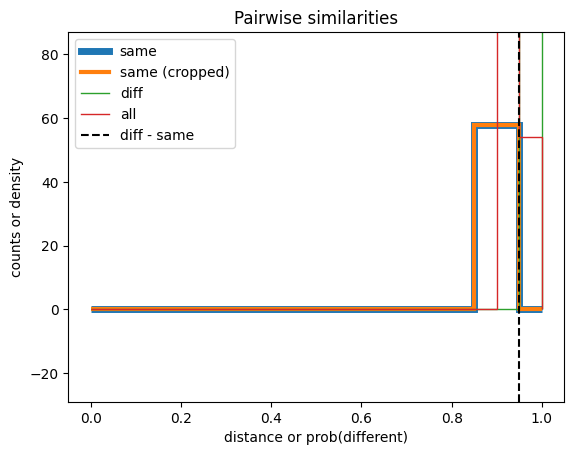

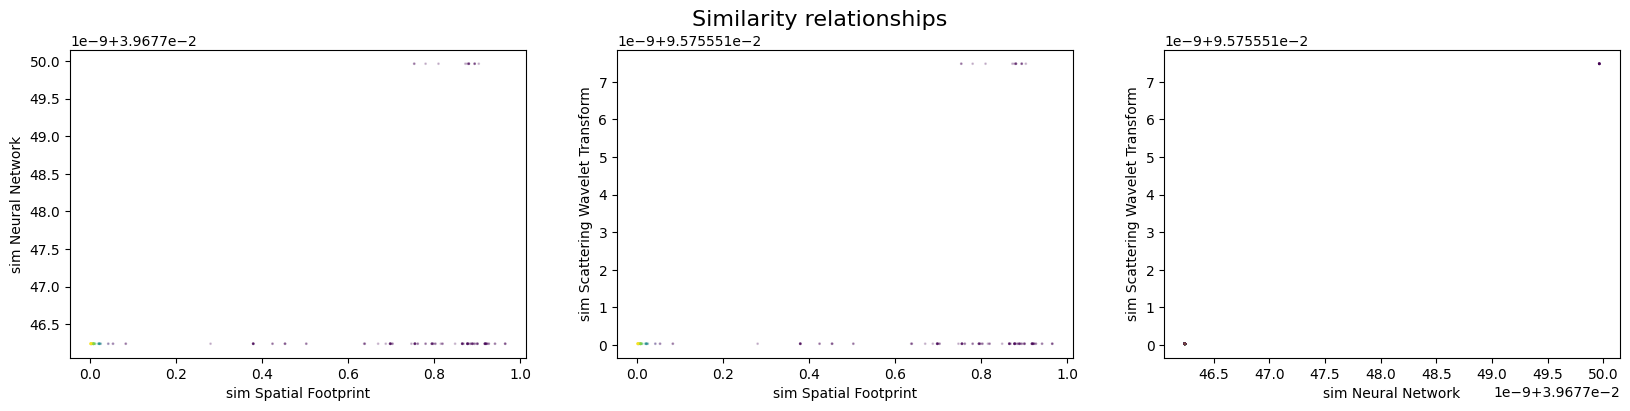

In [30]:
kwargs_mcdm_tmp = kwargs_makeConjunctiveDistanceMatrix_best  ## Use the optimized parameters

### Uncomment below to manually specify mixing parameters
# kwargs_mcdm_tmp = {
#     'power_SF': 1.0,   ## s_sf**power_SF   (Higher values means clustering is more sensitive to spatial overlap of ROIs)
#     'power_NN': 1.0,   ## s_NN**power_NN   (Higher values means clustering is more sensitive to visual similarity of ROIs)
#     'power_SWT': 0.0,  ## s_SWT**power_SWT (Higher values means clustering is more sensitive to visual similarity of ROIs)
#     'p_norm': -4.0,    ## norm([s_sf, s_NN, s_SWT], p=p_norm) (Higher values means clustering requires all similarity metrics to be high)
# #         'sig_SF_kwargs': {'mu':0.5, 'b':1.0},  ## Sigmoid parameters for s_sf (mu is the center, b is the slope)
#     'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':1.0, 'b':0.5},    ## Sigmoid parameters for s_NN (mu is the center, b is the slope)
# #     'sig_NN_kwargs': None,
# #         'sig_SWT_kwargs': {'mu':0.5, 'b':1.0}, ## Sigmoid parameters for s_SWT (mu is the center, b is the slope)
#     'sig_SWT_kwargs': None,
# }

clusterer.plot_distSame(kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp)

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000,  ## Make smaller if it is running too slow
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp
);

**`'No crossover found, not plotting'`: Thus trying out the manual method.**

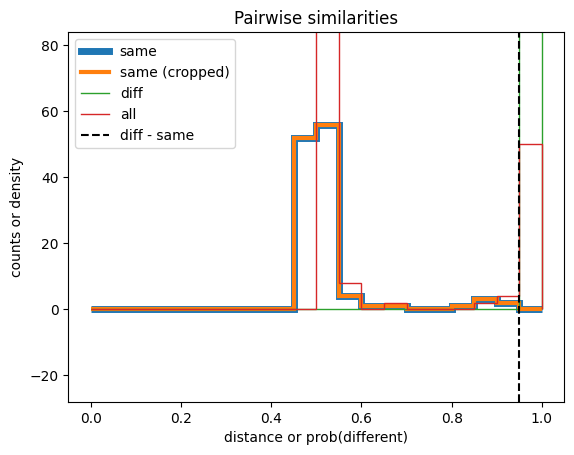

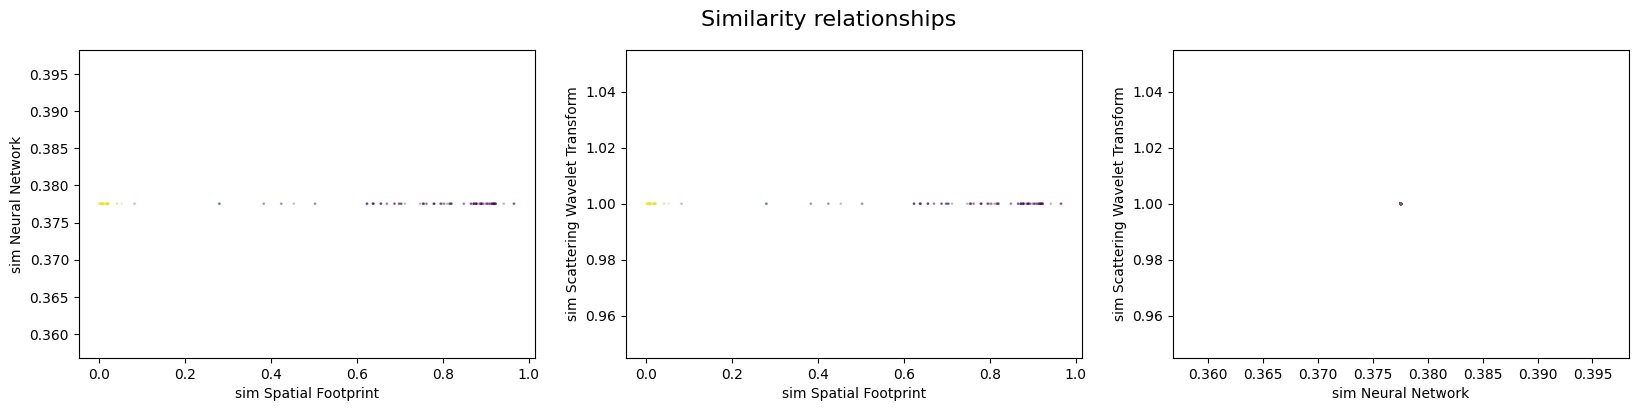

In [31]:
kwargs_mcdm_tmp = kwargs_makeConjunctiveDistanceMatrix_best  ## Use the optimized parameters

### Uncomment below to manually specify mixing parameters
kwargs_mcdm_tmp = {
    'power_SF': 1.0,   ## s_sf**power_SF   (Higher values means clustering is more sensitive to spatial overlap of ROIs)
    'power_NN': 1.0,   ## s_NN**power_NN   (Higher values means clustering is more sensitive to visual similarity of ROIs)
    'power_SWT': 0.0,  ## s_SWT**power_SWT (Higher values means clustering is more sensitive to visual similarity of ROIs)
    'p_norm': -4.0,    ## norm([s_sf, s_NN, s_SWT], p=p_norm) (Higher values means clustering requires all similarity metrics to be high)
#         'sig_SF_kwargs': {'mu':0.5, 'b':1.0},  ## Sigmoid parameters for s_sf (mu is the center, b is the slope)
    'sig_SF_kwargs': None,
        'sig_NN_kwargs': {'mu':1.0, 'b':0.5},    ## Sigmoid parameters for s_NN (mu is the center, b is the slope)
#     'sig_NN_kwargs': None,
#         'sig_SWT_kwargs': {'mu':0.5, 'b':1.0}, ## Sigmoid parameters for s_SWT (mu is the center, b is the slope)
    'sig_SWT_kwargs': None,
}

clusterer.plot_distSame(kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp)

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000,  ## Make smaller if it is running too slow
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp
);

##### 2. Prune the distance matrix

We can remove all connections in the distance graph with probabilities of connection of less than 50%. We estimate this cutoff distance as the cross-over point between the 'same' and 'different' distributions.

**Important parameter**\
`stringency`: This value changes the threshold for pruning the distance matrix. A higher value will result in less pruning, and a lower value will result in more pruning. The value will be multiplied by the inferred threshold to get the new one.


In [32]:
clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,  ## Optionally manually specify a distance cutoff
    kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp,
    stringency=1.0,  ## Modifies the threshold for pruning the distance matrix. Higher values result in LESS pruning. New d_cutoff = stringency * truncated d_cutoff.
    convert_to_probability=False,    
)

Pruning similarity graphs with d_cutoff = 0.949999988079071...


/opt/conda/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


##### 3. Cluster

There are two methods for clustering: The standard method `.fit` which is based on HDBSCAN, and `.fit_sequentialHungarian` which is an algorithm that is also used by CaImAn based on the Hungarian algorithm. The standard method takes 1-20 minutes and works better when there are many sessions, the Hungarian method takes seconds and works better when there are fewer sessions (<8).

**Important parameters**:
- For standard **`.fit`** method:
1. `min_cluster_size`: If you only want ROIs clusters with at least a certain number of samples, specify here.
2. `n_iter_violationCorrection`: This parameter controls how fast this step takes. Turning it down has mild effects on quality. We use around ***6***.

- For **`.fit_sequentialHungarian`** method:
1. `thresh_cost`: Determines the threshold of how distant two ROIs can be and still be matched. Smaller value is more stringent.


In [33]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        min_cluster_size=2,  ## Minimum number of ROIs that can be considered a 'cluster'
        n_iter_violationCorrection=6,  ## Number of times to redo clustering sweep after removing violations
        split_intraSession_clusters=True,  ## Whether or not to split clusters with ROIs from the same session
        cluster_selection_method='leaf',  ## (advanced) Method of cluster selection for HDBSCAN (see hdbscan documentation)
        d_clusterMerge=None,  ## Distance below which all ROIs are merged into a cluster
        alpha=0.999,  ## (advanced) Scalar applied to distance matrix in HDBSCAN (see hdbscan documentation)
        discard_failed_pruning=True,  ## (advanced) Whether or not to set all ROIs that could be separated from clusters with ROIs from the same sessions to label=-1
        n_steps_clusterSplit=100,  ## (advanced) How finely to step through distances to remove violations
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        thresh_cost=0.6,  ## Threshold 
    )

Clustering with CaImAn's sequential Hungarian algorithm method...


100%|██████████| 1/1 [00:00<00:00, 782.37it/s]


##### 4. Quality metrics

Compute various quality scores for each cluster and each ROI.

In [34]:
## SKIP THIS STEP FOR VERY LARGE DATASETS
quality_metrics = clusterer.compute_quality_metrics();

## Collect results

1. Make different versions of the labels for convenience.
2. Put all the useful results and info into a dictionary to save later. ADJUST THIS ANY WAY YOU WANT.
3. Put all the class objects from the run into a dictionary to save later

In [35]:
# labels_squeezed, labels_bySession, labels_bool, labels_bool_bySession, labels_dict = roicat.tracking.clustering.make_label_variants(labels=labels, n_roi_bySession=data.n_roi)

# results = {
#     "clusters":{
#         "labels": labels_squeezed,
#         "labels_bySession": labels_bySession,
#         "labels_bool": labels_bool,
#         "labels_bool_bySession": labels_bool_bySession,
#         "labels_dict": labels_dict,
#     },
#     "ROIs": {
#         "ROIs_aligned": aligner.ROIs_aligned,
#         "ROIs_raw": data.spatialFootprints,
#         "frame_height": data.FOV_height,
#         "frame_width": data.FOV_width,
#         "idx_roi_session": np.where(data.session_bool)[1],
#         "n_sessions": data.n_sessions,
#     },
#     "input_data": {
#         "paths_stat": data.paths_stat,
#         "paths_ops": data.paths_ops,
#     },
#     "quality_metrics": clusterer.quality_metrics if hasattr(clusterer, 'quality_metrics') else None,
# }

**We don't have the Suite2p input_data** 

In [36]:
labels_squeezed, labels_bySession, labels_bool, labels_bool_bySession, labels_dict = roicat.tracking.clustering.make_label_variants(labels=labels, n_roi_bySession=data.n_roi)

results = {
    "clusters":{
        "labels": labels_squeezed,
        "labels_bySession": labels_bySession,
        "labels_bool": labels_bool,
        "labels_bool_bySession": labels_bool_bySession,
        "labels_dict": labels_dict,
    },
    "ROIs": {
        "ROIs_aligned": aligner.ROIs_aligned,
        "ROIs_raw": data.spatialFootprints,
        "frame_height": data.FOV_height,
        "frame_width": data.FOV_width,
        "idx_roi_session": np.where(data.session_bool)[1],
        "n_sessions": data.n_sessions,
    },
    # "input_data": {
    #     "paths_stat": data.paths_stat,
    #     "paths_ops": data.paths_ops,
    # },
    "quality_metrics": clusterer.quality_metrics if hasattr(clusterer, 'quality_metrics') else None,
}

In [37]:
run_data = copy.deepcopy({
    'data': data.serializable_dict,
    'aligner': aligner.serializable_dict,
    'blurrer': blurrer.serializable_dict,
    'roinet': roinet.serializable_dict,
    'swt': swt.serializable_dict,
    'sim': sim.serializable_dict,
    'clusterer': clusterer.serializable_dict,
})

# Visualize results

In [38]:
print(f'Number of clusters: {len(np.unique(results["clusters"]["labels"]))}')
print(f'Number of discarded ROIs: {(results["clusters"]["labels"]==-1).sum()}')

Number of clusters: 57
Number of discarded ROIs: 75


Look at some of the distributions of the quality metrics.
- Silhouette score is a particularly useful one for this type of clustering. Learn more here: https://en.wikipedia.org/wiki/Silhouette_(clustering)
- We also define a handy 'confidence' variable which is a nice heuristic you can use for thresholding for inclusion criteria
- Note that the `sample_silhouette` score is a per-sample (per-ROI) score. So it can actually be used to remove / subselect ROIs from clusters.

A good rule of thumb is to use an inclusion criteria of:
- `sample_silhouette` > 0.1
- `cluster_silhouette` > 0.2

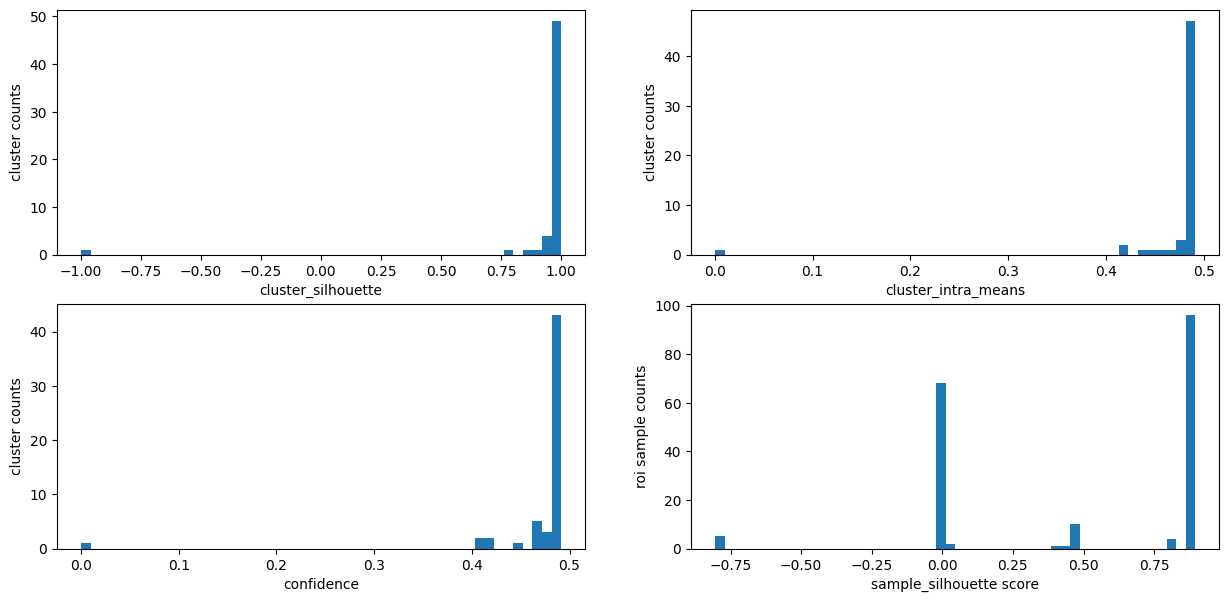

In [39]:
confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['quality_metrics']['cluster_silhouette'], 50);
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['quality_metrics']['cluster_intra_means'], 50);
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence, 50);
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

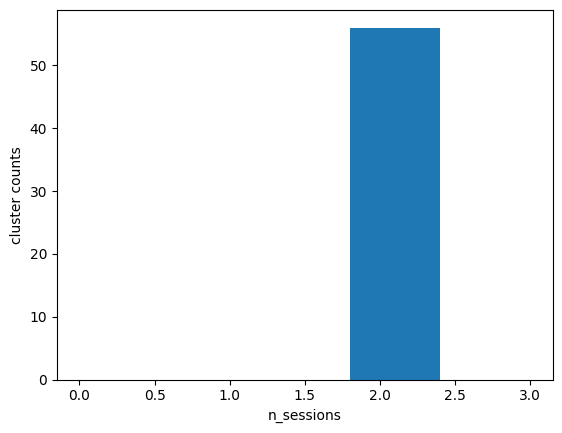

In [40]:
_, counts = np.unique(results['clusters']['labels'], return_counts=True)

plt.figure()
plt.hist(counts, results['ROIs']['n_sessions']*2 + 1, range=(0, results['ROIs']['n_sessions']+1));
plt.xlabel('n_sessions'), plt.ylabel('cluster counts');

Look at a color visualization of the results. ROIs of the same color are considered a part of the same cluster. The colors are assigned randomly.

In [41]:
FOV_clusters = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in results['ROIs']['ROIs_aligned']],  ## Spatial footprint sparse arrays
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    labels=results["clusters"]["labels_bySession"],  ## cluster labels
    # alphas_labels=confidence*1.5,  ## Set brightness of each cluster based on some 1-D array
    alphas_labels=(clusterer.quality_metrics['cluster_silhouette'] > 0) * (clusterer.quality_metrics['cluster_intra_means'] > 0.4),
#     alphas_sf=clusterer.quality_metrics['sample_silhouette'],  ## Set brightness of each ROI based on some 1-D array
)


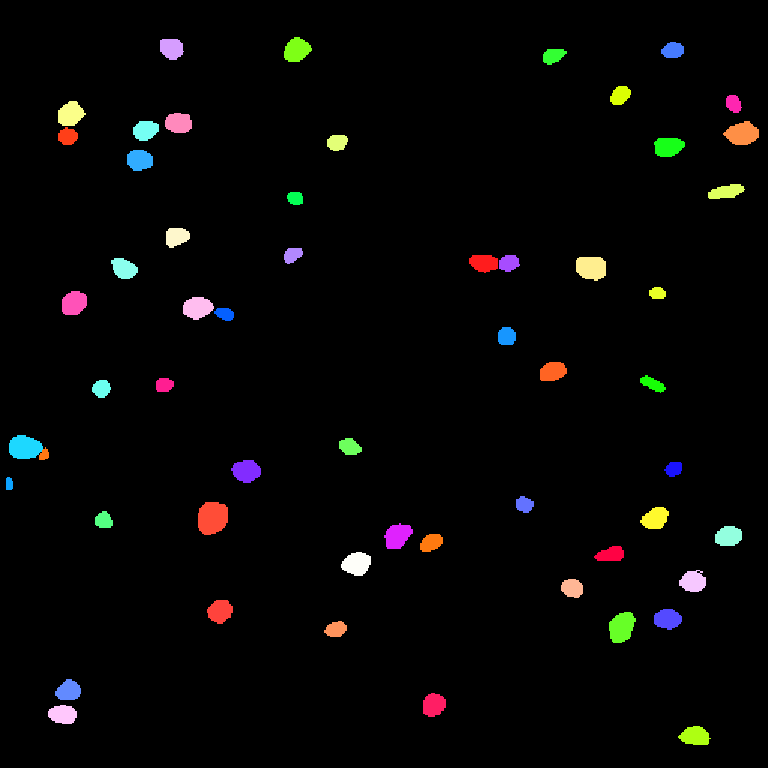

In [42]:
roicat.visualization.display_toggle_image_stack(
    FOV_clusters, 
    image_size=1.5,
#     clim=[0,1.0],
)

Visualize the images of ROIs from the same cluster

/opt/conda/lib/python3.10/site-packages/roicat/visualization.py:340: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(40,1))


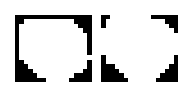

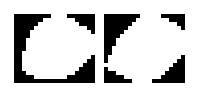

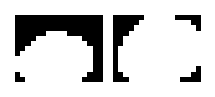

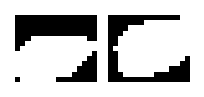

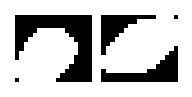

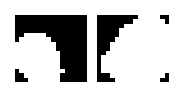

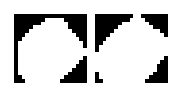

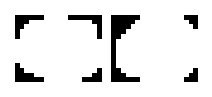

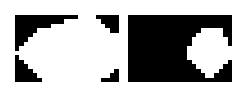

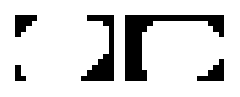

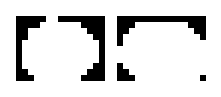

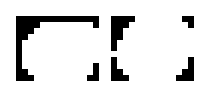

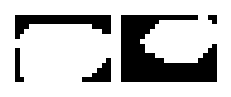

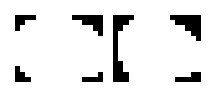

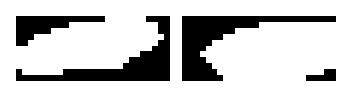

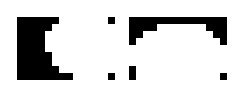

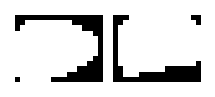

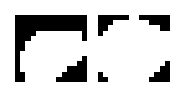

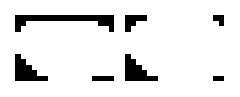

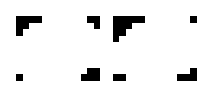

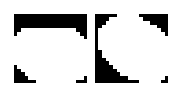

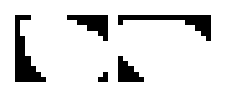

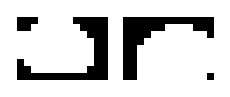

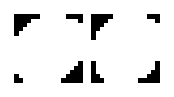

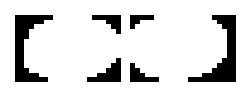

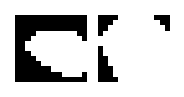

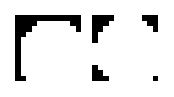

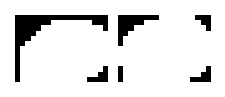

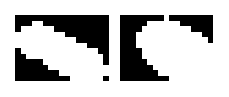

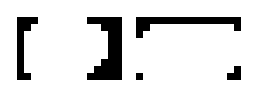

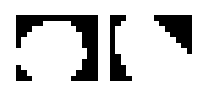

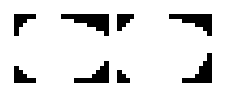

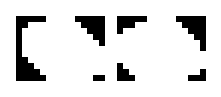

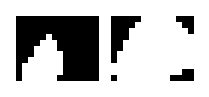

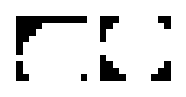

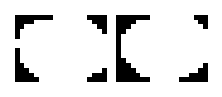

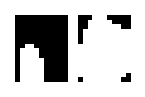

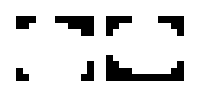

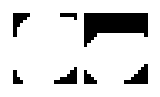

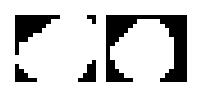

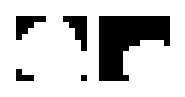

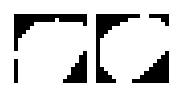

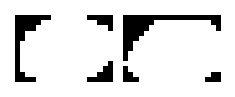

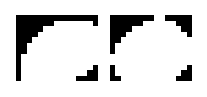

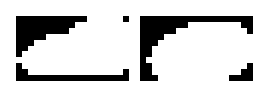

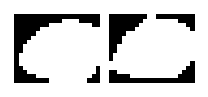

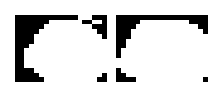

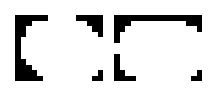

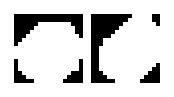

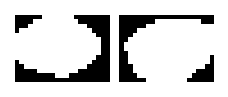

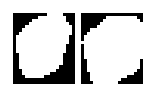

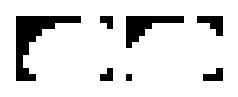

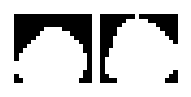

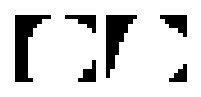

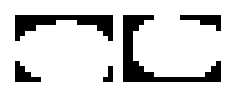

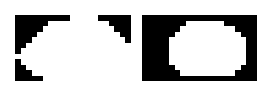

In [43]:
roicat.visualization.display_cropped_cluster_ims(
    spatialFootprints=results['ROIs']['ROIs_aligned'],
    labels=results["clusters"]["labels"],
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    n_labels_to_display=100,    
)

# Save results

In [44]:
# dir_save = Path('/media/rich/bigSSD/analysis_data/face_rhythm/mouse_2_6').resolve()
# name_save = Path(dir_allOuterFolders).resolve().name

# path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
# print(f'path_save: {path_save}')

In [45]:
dir_save = Path('/results').resolve()
name_save = "multiplane-ophys_636496"

path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
print(f'path_save: {path_save}')

path_save: /results/multiplane-ophys_636496.ROICaT.tracking.results.pkl


In [46]:
roicat.helpers.pickle_save(
    obj=results,
    filepath=path_save,
    mkdir=True,
)

roicat.helpers.pickle_save(
    obj=run_data,
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.rundata' + '.pkl')),
    mkdir=True,
)


Optionally save the FOV_clusters images as a GIF

In [47]:
roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[(f * 255).astype(np.uint8) for f in FOV_clusters], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=3,
        line_width=10,
        position=(30, 90),
    ), 
    path=str(Path(dir_save).resolve() / 'FOV_clusters.gif'),
    frameRate=10.0,
    loop=0,
)

Optionally save results as a matlab file.

In [48]:
# roicat.helpers.matlab_save(
#     obj=results,
#     filepath='/home/rich/Desktop/results.mat',
# )